In [1]:
import numpy as np
import pandas as pd
import statsmodels.api as sm
from scipy.stats import zscore
import matplotlib.pyplot as plt 
from statsmodels import regression
from statsmodels.tsa.stattools import coint

In [2]:
class senninha_long_and_short():
    def __init__(self,dados,t1,t2, financeiro_inicial, zs_l):
        #temos o par de tickers, os dados históricos de preço, e as variações históricas.
        self.zs_critico = zs_l
        self.t1, self.t2 = t1,t2
        self.dados = dados[['time',t1,t2]]
        self.dados_var = dados[[t1,t2]].pct_change()[1:]
        self.dados = self.dados[1:]
        self.s1, self.s2 = self.dados[self.t1], self.dados[self.t2]
        self.s1_var, self.s2_var = self.dados_var[self.t1], self.dados_var[self.t2]
        self.financeiro = financeiro_inicial
        #variaveis iniciais para tradar pares
        self.posicionado = 0
        self.compra_s1 = 0
        self.venda_s2 = 0
        #desempenho ao longo do tempo 
        self.l_resultado = []
        self.l_pct_operacoes = []
        self.l_evolucao = []
        self.l_dias_carregando = []
        self.variavel_contagem_dias = 0
        
    def calcula_zscore_spread(self,stock1,stock2):
        stock1 = sm.add_constant(stock1)
        results = sm.OLS(stock2,stock1).fit()
        stock1 = stock1[self.t1]
        b = results.params[self.t1]
        spread = stock2 - (b*stock1)
        zs = zscore(spread)[-1]
        return zs, b
    
    def print_resultados(self, tipo, r): #rlong,rshort,result
        if tipo == 'entrada':
            print(f'entrou | V1 {self.venda_s1:.2f} X {self.v1} | C2 {self.compra_s2:.2f} X {self.v2}')
        elif tipo == 'saida':
            print(f'saiu   | C1 {self.compra_s1:.2f} X {self.v1} | V2 {self.venda_s2:.2f} X {self.v2}')
        elif tipo == 'resultado':
            print(f'result | s1 {r[0]:.2f} | s2 {r[1]:.2f} | l/p = {r[2]:.2f}\n')
    
    def condicoes_operar(self, zs_atual, cotacao1, cotacao2,indice):
        if zs_atual >= self.zs_critico and self.posicionado == 0:
            razao = cotacao1/cotacao2
            volume = (self.financeiro/2)//cotacao1
            self.v1, self.v2 = int(volume), int(razao*volume)
            #definiu o numero de ações que comprará de cada
            self.venda_s1 = cotacao1*self.v1
            self.compra_s2  = cotacao2*self.v2 
            self.valor_total_trade = self.venda_s1+self.compra_s2
           # self.print_resultados('entrada',r=None)
            self.posicionado = 1
            self.variavel_contagem_dias = indice
        elif zs_atual <= 0.08 and self.posicionado == 1:
            self.posicionado = 0    
            self.l_dias_carregando.append(indice-self.variavel_contagem_dias)
            #encerra posicao
            self.compra_s1 = cotacao1*self.v1
            self.venda_s2  = cotacao2*self.v2 
            #self.print_resultados('saida',r=None)
            #resultado
            resultado_long  = self.venda_s1 - self.compra_s1
            resultado_short = self.venda_s2 - self.compra_s2
            resultado = resultado_long + resultado_short
            pct_operacao = (resultado/self.valor_total_trade)*100
            #resultados ao longo do tempo
            self.l_pct_operacoes.append(pct_operacao)
            self.l_resultado.append(resultado)
            #self.print_resultados('resultado',[resultado_long,resultado_short,resultado])
            self.financeiro += resultado
            #reseta valor em carteira de cada ação
            self.compra_s1, self.venda_s1, self.compra_s2 ,self.venda_s2,  = 0, 0, 0, 0
            resultado, resultado_long, resultado_short = 0, 0, 0
        self.l_evolucao.append(self.financeiro)

    def loop_operador(self, window_size):
        c = 0
        for index in range(window_size, len(self.s1)):
            #stock data in the window range
            s1_var_w, s2_var_w = self.s1_var[c:index], self.s2_var[c:index]
            preco_s1, preco_s2 = self.s1[self.dados.index == index].values[0], self.s2[self.dados.index == index].values[0]
            #calculates the zscore of the spread
            resultado_funcao = self.calcula_zscore_spread(s1_var_w, s2_var_w)
            zs, beta = resultado_funcao[0], resultado_funcao[1]
            self.condicoes_operar(zs_atual=zs, cotacao1=preco_s1, cotacao2=preco_s2,indice=index)   
            c+=1

In [3]:
dados = pd.read_excel('dados_senninha_ls.xlsx')[2:] #windows

new_columns = []
for nome in dados.columns.to_list():
    new_columns.append(nome[6:])

new_columns[0] = 'time'
dados.columns = new_columns

In [93]:
dados[45:]

,time,IBOV,ABEV3,AZUL4,B3SA3,BBAS3,BBDC3,BBDC4,BBSE3,BEEF3,...,TAEE11,TIMP3,TOTS3,UGPA3,USIM5,VALE3,VIVT4,VVAR3,WEGE3,YDUQ3
47,2016-04-01,50562,16.99,NaN,13.91,16.83,14.92,13.34,20.99,11.06,...,12.83,7.28,8.62,31.54,1.74,14.03,33.98,2.36,10.29,9.50
48,2016-04-04,48780,16.73,NaN,13.77,15.88,14.54,12.85,20.44,10.55,...,12.88,7.04,8.53,30.87,1.60,13.38,33.02,2.36,10.01,9.20
49,2016-04-05,49054,16.92,NaN,13.95,15.62,14.55,12.92,20.43,10.55,...,12.79,6.79,8.49,31.35,1.55,13.83,32.45,NaN,9.96,9.26
50,2016-04-06,48096,16.73,NaN,13.36,15.48,14.13,12.52,20.10,10.47,...,12.74,6.66,8.56,31.67,1.41,13.63,31.61,NaN,10.06,9.30
51,2016-04-07,48513,16.72,NaN,13.53,15.95,14.30,12.63,20.78,10.21,...,12.77,6.76,8.79,32.00,1.43,13.58,32.22,NaN,9.99,9.28
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
970,2019-12-20,115121,18.91,57.00,47.96,50.45,30.09,32.23,34.54,12.08,...,29.52,15.20,22.70,24.30,9.24,53.59,55.25,11.37,33.69,47.23
971,2019-12-23,115863,18.96,57.60,45.78,51.98,30.70,32.43,34.73,12.07,...,29.71,15.31,22.44,25.01,9.44,53.38,55.74,11.67,33.63,48.09
972,2019-12-26,117203,19.22,57.07,45.57,52.57,31.02,32.83,34.56,12.64,...,30.05,15.51,22.28,25.28,9.44,53.59,56.23,11.80,34.68,47.70
973,2019-12-27,116534,19.16,57.80,43.19,52.34,30.82,32.71,34.63,12.74,...,29.97,15.51,21.56,25.40,9.34,53.60,55.84,11.50,35.17,47.90


In [4]:
dic_dados_pares = {}

In [5]:
zsl = 1.1
b_pairs = [['CSNA3','MRFG3'],['BRAP4','MRFG3'],['CMIG4','USIM5'],['HGTX3','USIM5'],['CMIG4','MRVE3'],['QUAL3','USIM5'],['BRKM5','MRFG3'],['CMIG4','MRFG3'],['MULT3','USIM5'],['GGBR4','MRFG3'],['GOAU4','MRFG3'],['ABEV3','MRFG3'],['JBSS3','MRFG3'],['RADL3','USIM5'],['ITSA4','MRFG3'],['EQTL3','MRFG3'],['EQTL3','JBSS3'],['BRML3','JBSS3'],['BRAP4','IGTA3'],['GOAU4','JBSS3'],['BRML3','CSNA3'],['ITSA4','USIM5'],['LREN3','USIM5'],['BRKM5','USIM5'],['CYRE3','JBSS3'],['ITSA4','JBSS3'],['BBDC4','JBSS3'],['PETR4','USIM5'],['LREN3','MRVE3'],['BRFS3','CSNA3'],['HGTX3','SUZB3'],['BTOW3','USIM5'],['PETR3','SUZB3'], ['BTOW3','JBSS3'],['BBAS3','CSNA3'],['HGTX3','PETR3'],['BBDC4','CSNA3'],['CMIG4','RAIL3'],['EMBR3','SUZB3'],['HGTX3','RAIL3']]
for i in b_pairs:
    dic_dados_pares[str(i)] = senninha_long_and_short(dados,i[0], i[1], 10000,zs_l = zsl)
    dic_dados_pares[str(i)].loop_operador(window_size=45)

In [6]:
import random
print('Alguns resultados sobre qual a quantidade financeira final de determinados pares que começaram com R$10k:')
for k,v in dic_dados_pares.items():
    ran = random.randint(0,4)
    if ran == 1:
        print(f'{k}: {v.financeiro:.2f}')

Alguns resultados sobre qual a quantidade financeira final de determinados pares que começaram com R$10k:
['CSNA3', 'MRFG3']: 23577.24
['CMIG4', 'USIM5']: 26327.34
['GOAU4', 'MRFG3']: 20252.70
['BRML3', 'JBSS3']: 18897.54
['BRKM5', 'USIM5']: 36058.98
['LREN3', 'MRVE3']: 16083.34
['BTOW3', 'USIM5']: 37251.33
['PETR3', 'SUZB3']: 36399.00
['BBAS3', 'CSNA3']: 30556.61


In [7]:
tamanho = len(dic_dados_pares["['BRML3', 'CSNA3']"].l_evolucao)
l_carteira_total = [0]*tamanho
pct_senninha_tempo = [0]

l_carteira_evolucao_pct = [1]
for i in range(tamanho):
    for k,v in dic_dados_pares.items():
        l_carteira_total[i] += v.l_evolucao[i]
        
for i in range(1,len(l_carteira_total)):
    pct = ((l_carteira_total[i]-l_carteira_total[i-1])/l_carteira_total[i-1])
    pct_senninha_tempo.append(pct)
    l_carteira_evolucao_pct.append((l_carteira_evolucao_pct[i-1]*(1+pct)))

In [8]:
l_dias = dados['time'].to_list()
var_ibov = (dados['IBOV'].pct_change())[1:].to_list()[45:]
ibov_acumulado = []
jj = 1
for i in range(len(var_ibov)):
    jj *= (1+var_ibov[i])
    ibov_acumulado.append(jj)

<ipython-input-34-0117eb77dbc6>:9: UserWarning: FixedFormatter should only be used together with FixedLocator
  plt.gca().set_yticklabels(['{:.0f}%'.format((x*100)-100) for x in plt.gca().get_yticks()],fontsize=18)


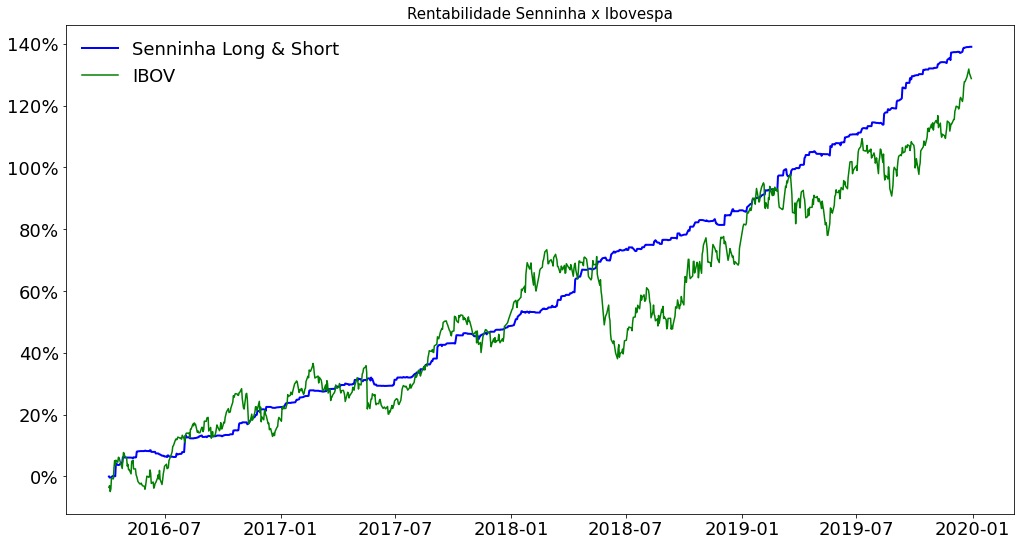

In [34]:
plt.labelsize = 16
fig = plt.figure(figsize=(17, 9))
plt.plot(l_dias[46:],l_carteira_evolucao_pct,color='b',linewidth=2, label='Senninha Long & Short')
plt.plot(l_dias[46:],ibov_acumulado,color='g', label='IBOV')
plt.title('Rentabilidade Senninha x Ibovespa',fontsize=15)
plt.xticks(size = 18)
# plt.ylabel('Evolução',fontsize=18)
plt.legend(loc='best', frameon=False, fontsize=18)
plt.gca().set_yticklabels(['{:.0f}%'.format((x*100)-100) for x in plt.gca().get_yticks()],fontsize=18)
plt.savefig('desempenohsenninha.png', dpi=300)
plt.show()

In [152]:
total_dias_periodo = 1368 #esse inclui todos os dias, inclusive final de semanas e feriados

num_trades = []
dur_trades = []
for k,v in dic_dados_pares.items():
    num_trades.append(len(v.l_dias_carregando))
    dur_trades.append(v.l_dias_carregando)
    
mu_trades_mes = (np.sum(num_trades))/(total_dias_periodo/30)
print('Duração do período 3 anos, 8 meses, 30 dias\n')
print(f'Numero total de trades no período: {np.sum(num_trades)} operações.')
print(f'Média  anual de trades no período: {int(mu_trades_mes*12)}  operações.')
print(f'Média mensal de trades no período: {int(mu_trades_mes)}   operações.')


Duração do período 3 anos, 8 meses, 30 dias

Numero total de trades no período: 3739 operações.
Média  anual de trades no período: 983  operações.
Média mensal de trades no período: 81   operações.


In [11]:
media_holding = []
for i in dur_trades:
    media_holding.append(np.mean(i))

holding_series = pd.Series(media_holding)
print(f'Holding médio: {np.mean(media_holding):.2f} dias.')

Holding médio: 1.73 dias.


In [12]:
print('Estatísticas da médias de holding de todos pares:\n')
print(holding_series.describe())

Estatísticas da médias de holding de todos pares:

count    40.000000
mean      1.730218
std       0.085284
min       1.570000
25%       1.662191
50%       1.720465
75%       1.788278
max       1.942529
dtype: float64


In [179]:
ibov_series, senninha_series = pd.Series(var_ibov)*100, pd.Series(pct_senninha_tempo)*100
print(f'Describe das variações Ibovespa em %:\n\n{ibov_series.describe()} \n')
print(f'Describe das variações Senninha em %:\n\n{senninha_series.describe()}')

Describe das variações Ibovespa em %:

count    927.000000
mean       0.097737
std        1.298437
min       -8.799230
25%       -0.647332
50%        0.123276
75%        0.895933
max        4.569860
dtype: float64 

Describe das variações Senninha em %:

count    927.000000
mean       0.094658
std        0.355258
min       -1.314726
25%        0.000000
50%        0.000000
75%        0.088030
max        4.168799
dtype: float64


In [178]:
def c_retorno(r_total):
    total = r_total[-1] - 1
    mensal = total**(1/45)
    anual = ((mensal)**12 - 1)*100
    mensal = (mensal-1)*100
    return anual,mensal
print('Duração do período 3 anos, 8 meses, 30 dias\n')
print(f'Retorno anual  Senninha no período: {c_retorno(l_carteira_evolucao_pct)[0]:.2f}%')
print(f'Retorno mensal Senninha no período: {c_retorno(l_carteira_evolucao_pct)[1]:.4f}%\n')

print(f'Retorno anual  Ibov no período: {c_retorno(ibov_acumulado)[0]:.2f}%')
print(f'Retorno mensal Ibov no período: {c_retorno(ibov_acumulado)[1]:.4f}%\n')


Duração do período 3 anos, 8 meses, 30 dias

Retorno anual  Senninha no período: 9.18%
Retorno mensal Senninha no período: 0.7345%

Retorno anual  Ibov no período: 6.96%
Retorno mensal Ibov no período: 0.5626%



In [177]:
print(f'Maior queda em um dia Senninha: {senninha_series.min():.2f} % ')
print(f'Maior queda em um dia Ibovespa: {ibov_series.min():.2f} %\n')

print(f'Maior valorização em um dia Senninha: {senninha_series.max():.2f} %')
print(f'Maior valorização em um dia Ibovespa: {ibov_series.max():.2f} %\n')

print(f'Variação média em um dia Senninha: {senninha_series.mean():.3f} %, desvio padrão: {senninha_series.std():.2f} %')
print(f'Variação média em um dia Ibovespa: {ibov_series.mean():.3f} %, desvio padrão: {ibov_series.std():.2f} %')


Maior queda em um dia Senninha: -1.31 % 
Maior queda em um dia Ibovespa: -8.80 %

Maior valorização em um dia Senninha: 4.17 %
Maior valorização em um dia Ibovespa: 4.57 %

Variação média em um dia Senninha: 0.095 %, desvio padrão: 0.36 %
Variação média em um dia Ibovespa: 0.098 %, desvio padrão: 1.30 %


In [14]:
covariance = np.cov(var_ibov,pct_senninha_tempo)[1][0]
print(f'Covariância entre IBOV e Senninha: {covariance:.8f}')

Covariância entre IBOV e Senninha: 0.00000156


In [15]:
import statsmodels.tsa.stattools as ts 
result=ts.coint(var_ibov, pct_senninha_tempo)[1]
if result <= 0.05:
    print(f'{result:.5f} -> Ibov e Senninha não são cointegrados')

0.00000 -> Ibov e Senninha não são cointegrados


Financeiro de alguns pares ao longo do tempo com posição inicial de R$10k:


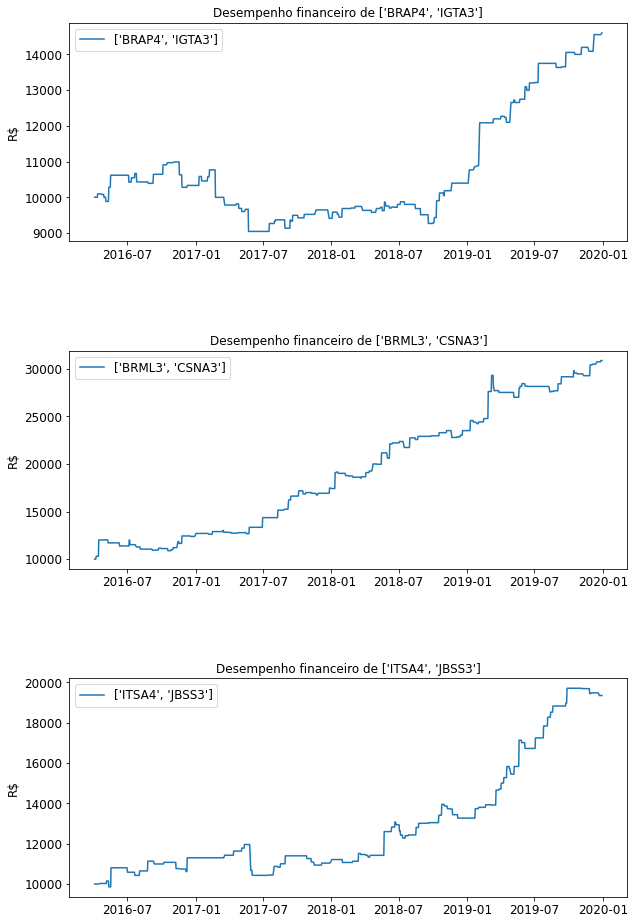

In [88]:
fig = plt.figure(figsize=(10, 50))
plt.subplots_adjust(left=None, bottom=0, right=None, top=None, wspace=None, hspace=.5)
contador1 = 1
print('Financeiro de alguns pares ao longo do tempo com posição inicial de R$10k:')

for k,v in dic_dados_pares.items():
    ran = random.randint(0,8)
    if ran == 1 and contador1 <= 3:
        plt.subplot(10, 1, contador1)
        plt.title('Desempenho financeiro de '+ k, fontsize=12)
#         plt.xlabel('Dias')
        plt.ylabel('R$', fontsize=12)
        plt.xticks(size = 12)
        plt.yticks(size = 12)

        plt.plot(l_dias[46:],v.l_evolucao, label=k)
        plt.legend(loc='best', frameon=True, fontsize=12)
        contador1 += 1
        


In [89]:
print(l_carteira_evolucao_pct[-1])
print(ibov_acumulado[-1])

2.3900000500000016
2.2871919623432624


In [100]:
(1.007)**45

1.3687564380080417

In [131]:
(1.2871919623432624)**(1/45) - 1

0.005626057649406713

In [133]:
((1.005626057649406713)**(12) -1)*100

6.964143621109531